# Project: Wrangle and Visualize Data
## Twitter _WeRateDogs_ Case

In [1]:
# Setting up my environment by important core packages
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import html5lib
import requests
import tweepy
import json
import glob
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Gathering Data

In [2]:
# Loading the twitter archived data into a pandas  dataframe
df_1 = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# Let's download the HTML programmaticaly by sending a GET request to the url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url, allow_redirects = True)

# Saving TSV to file
with open("image-predictions.tsv", mode = 'wb') as file:
    file.write(response.content)
    
soup = BeautifulSoup(response.content, 'lxml')

In [4]:
df_2 = pd.read_csv('image-predictions.tsv', sep = '\t')

In [5]:
# Loading the json file into a pandas dataframe
df_3 = pd.read_json('tweet.json', lines = True)

# Assessing Data
### Visual Assessment

In [6]:
# Display twitter-archive-enhanced Table
df_1

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [7]:
# Display image-predictions Table
df_2

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [8]:
# Display tweet Table
df_3

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2350,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,311,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2351,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,128,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2352,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,132,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


### Programmatic Assessment

In [9]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [12]:
df_1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
df_2.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [14]:
df_3.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,0.0,0.0,0.0,2354.000000,2354.000000,2211.0,2211.0,2.900000e+01,2.900000e+01
mean,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,NaN,NaN,NaN,3164.797366,8080.968564,0.0,0.0,8.162686e+17,8.162686e+17
std,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,NaN,NaN,NaN,5284.770364,11814.771334,0.0,0.0,6.164161e+16,6.164161e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,NaN,NaN,NaN,624.500000,1415.000000,0.0,0.0,7.888183e+17,7.888183e+17
50%,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1473.500000,3603.500000,0.0,0.0,8.340867e+17,8.340867e+17
75%,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,3652.000000,10122.250000,0.0,0.0,8.664587e+17,8.664587e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,79515.000000,132810.000000,0.0,0.0,8.860534e+17,8.860534e+17


In [15]:
df_1.sample(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
314,835172783151792128,NaN,NaN,2017-02-24 17:01:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in any no...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835172783...,12,10,None,None,None,None,None
2196,668852170888998912,NaN,NaN,2015-11-23 18:02:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bobb. Bobb is a Golden High Fescu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668852170...,11,10,Bobb,None,None,None,None
132,866816280283807744,NaN,NaN,2017-05-23 00:41:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Jamesy. He gives a kiss...,8.664507e+17,4.196984e+09,2017-05-22 00:28:40 +0000,https://twitter.com/dog_rates/status/866450705...,13,10,Jamesy,None,None,pupper,None
692,787111942498508800,NaN,NaN,2016-10-15 02:04:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Carl. He's very powerfu...,7.529324e+17,4.196984e+09,2016-07-12 18:27:35 +0000,"https://vine.co/v/OEppMFbejFz,https://vine.co/...",12,10,Carl,None,None,None,None


In [16]:
df_2.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1191,739932936087216128,https://pbs.twimg.com/media/CkTFEe-W0AA90m1.jpg,1,redbone,0.243904,True,beagle,0.210975,True,vizsla,0.076443,True
803,691483041324204033,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,1,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True
1224,744971049620602880,https://pbs.twimg.com/media/ClarNU8VAAEDrDt.jpg,1,toy_poodle,0.497755,True,golden_retriever,0.282017,True,miniature_poodle,0.090032,True
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,0.000055,False,acorn,0.000026,False
201,669682095984410625,https://pbs.twimg.com/media/CUswUBRUAAAahAo.jpg,1,Christmas_stocking,0.188397,False,studio_couch,0.086887,False,bookcase,0.082599,False
1849,839990271299457024,https://pbs.twimg.com/media/C6g-sX-VsAAHfJ9.jpg,2,Staffordshire_bullterrier,0.604938,True,American_Staffordshire_terrier,0.311540,True,Boston_bull,0.037159,True
1120,726828223124897792,https://pbs.twimg.com/media/ChY2aHyWMAAbNQE.jpg,1,miniature_pinscher,0.255327,True,Border_terrier,0.181279,True,Labrador_retriever,0.125185,True
145,668625577880875008,https://pbs.twimg.com/media/CUdvambWoAA007z.jpg,1,ox,0.071536,False,groenendael,0.054455,True,Angora,0.045028,False
168,668988183816871936,https://pbs.twimg.com/media/CUi5M7TXIAAY0gj.jpg,1,Arabian_camel,0.999614,False,bison,0.000228,False,llama,0.000067,False
42,666739327293083650,https://pbs.twimg.com/media/CUC74aTWoAInZey.jpg,1,miniature_poodle,0.546933,True,cocker_spaniel,0.165255,True,toy_poodle,0.095959,True


In [17]:
df_3.sample(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
1470,2016-01-31 23:42:03+00:00,693942351086120961,693942351086120960,This is Kobe. He's a Speckled Rorschach. Reque...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 693942347109928960, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1896,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2184,2015-11-24 02:38:07+00:00,668981893510119424,668981893510119424,Unique dog here. Oddly shaped tail. Long pink ...,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 668981889504514048, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,573,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1713,2015-12-25 03:00:14+00:00,680221482581123072,680221482581123072,This is CeCe. She's patiently waiting for Sant...,False,"[0, 78]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 680221462859542528, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1598,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1201,2016-04-02 15:25:47+00:00,716285507865542656,716285507865542656,This is Stephanus. She stays woke. 12/10 https...,False,"[0, 64]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 716285498407456768, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3041,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1703,2015-12-26 19:43:36+00:00,680836378243002368,680836378243002368,This is Ellie. She's secretly ferocious. 12/10...,False,"[0, 89]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 680836369753739264, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3766,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [18]:
df_1.duplicated().sum()

0

In [19]:
df_2.duplicated().sum()

0

In [20]:
df_1.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [21]:
df_2.jpg_url.value_counts()

https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg    2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg                                            2
                                                                                          ..
https://pbs.twimg.com/media/CXrmMSpUwAAdeRj.jpg                                            1
https://pbs.twimg.com/media/CXrawAhWkAAWSxC.jpg                                            1
https://pbs.twimg.com/media/CXrIntsUsAEkv0d.jpg                                            1
https://pbs.twimg.com/media/CXqcOHCUQAAugTB.jpg                                            1
https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg                       

In [22]:
df_3.full_text.value_counts()

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                      1
Army of water dogs here. None of them know where they're going. Have no real purpose. Aggressive barks. 5/10 for all https://t.co/A88x73TwMN       1
This is Louis. He's a rollercoaster of emotions. Incalculably fluffy. 12/10 would pet firmly https://t.co/17RGvOZO9P                               1
With great pupper comes great responsibility. 12/10 https://t.co/hK6xB042EP                                                                        1
Meet Trooper &amp; Maya. Trooper protects Maya from bad things like dognappers and Comcast. So touching. 11/10 for both https://t.co/c98k1IoZKy    1
                                                                                                                                                  ..
This is Finley. She's a Beneboop Cumbersplash. 12/10 I'd do unspeakable things for Finley https://t.co/dS8

In [23]:
df_3.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2219
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [24]:
all_columns = pd.Series(list(df_1) + list(df_2) + list(df_3))
all_columns[all_columns.duplicated()]

17                 tweet_id
37                   source
38    in_reply_to_status_id
40      in_reply_to_user_id
dtype: object

### Quality
#### "tweeter-archive-enhanced" table
- Poorly formatted timestamp columns (timestamp, retweeted_status_timestamp)
- Column names aren't clear enough
- Confusing names (a, an)
- Erroneous datatypes (tweet_id, retweeted_status_id, retweeted_status_user_id, in_reply_to_status_id, in_reply_to_user_id)
- Presence of non null values in retweet_related columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- Missing of so many information in columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- Retweeted data aren't revelant to the analysis (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- Extraneous columns (source, text, expanded_urls)

#### "image-predictions" table
- Erroneous datatype (tweet_id)
- Column names aren't clear enough (p1, p2, p3, p1_conf, p2_dog)
- Inconsistency in column values capitalization (p1, p2, p3)
- Inconsistency in word separation in column values (some with hyphen (-) others with underscore(_))

#### "tweet" table
- Poorly formatted dates (created_at column name)
- Erroneous datatypes (id, id_str, in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str)
- Entities column contains curly braces and square brackets due to the json format
- Missing of huge amount of informations in columns (in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str, in_reply_to_screen_name, geo, coordinates, place, contributors, retweeted_status, quoted_status_id, quoted_status_id_str, quoted_status)
- Missing information in some columns (extented_entities, possibly_sensitive, possibly_sensitive_appealable)
- Erroneous datatypes (in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str)
- Column values equal to zero (possibly_sensitive, possibly_sensitive_appealable)
- Retweeted data aren't relevant to the analysis (
- tweets beyond August 1st, 2017 aren't relevant since their image predictions are not available

### Tidiness
#### "tweeter-archive-enhanced" table
- There is one variable in four columns, each dog's name variable does not form a column (doggo, fluffer, pupper, puppo)

#### "image-predictions" table
- Image predictions are split up into several lines
- Prediction, confidence and breed of dogs (p, p_conf, p_dog) do not respectively form a single column

#### "tweet" table


# Cleaning Data

In [25]:
# Create a copy of the twitter-archive-enhanced dataframe
df_clean_1 = df_1.copy()

### Define
- Convert timestamp and retweeted_status_timestamp into datetime
- Rename name column into dog_name
- Remove confusing dogs' name
- Convert tweet_id, retweeted_status_id, retweeted_status_user_id, in_reply_to_status_id, in_reply_to_user_id into string datatype
- Remove rows that have values belonging to columns retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp  to get rid of retweets
- Ditch columns with most of the values missing
- Drop extraneous columns that aren't relevant to our questions
- Merge the four columns (doggo, fluffer, pupper, puppo) into one variable called dog_name
- Remove extraneous columns (source, text, expanded_urls)

### Code

In [26]:
# Convert timestamp and retweeted_status_timestamp into datetime
df_clean_1.timestamp = pd.to_datetime(df_clean_1.timestamp)

df_clean_1.retweeted_status_timestamp = pd.to_datetime(df_clean_1.retweeted_status_timestamp)

In [27]:
# Rename name column into dog_name
df_clean_1.rename(columns = {'name': 'dog_name'}, inplace = True)

In [28]:
# Remove confusing dogs' name
df_clean_1 = df_clean_1[df_clean_1.dog_name != 'a']
df_clean_1 = df_clean_1[df_clean_1.dog_name != 'an']

In [29]:
# Convert tweet_id, retweeted_status_id, retweeted_status_user_id, in_reply_to_status_id, in_reply_to_user_id into string datatype
id_columns = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id']
for i in id_columns:
    df_clean_1[i] = df_clean_1[i].astype(str)

In [30]:
#  Remove rows that have values belonging to columns retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp  to get rid of retweets
df_clean_retweet = df_clean_1[df_clean_1.retweeted_status_id.isnull()]
df_clean_retweet = df_clean_1[df_clean_1.retweeted_status_user_id.isnull()]
df_clean_retweet = df_clean_1[df_clean_1.retweeted_status_timestamp.isnull()]

In [31]:
# Ditch columns with most of the values missing and drop extraneous ones
drop_columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp', 'source', 'text', 'expanded_urls']
df_clean_retweet.drop(drop_columns, axis = 1, inplace = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_8264\2662791639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_retweet.drop(drop_columns, axis = 1, inplace = True)


In [32]:
# Replace None with ''
dog_columns = ['doggo', 'floofer', 'pupper', 'puppo', 'dog_name']
for p in dog_columns:
    df_clean_retweet[p] = df_clean_retweet[p].str.replace('None', '', regex = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_8264\4013537474.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_retweet[p] = df_clean_retweet[p].str.replace('None', '', regex = True)


In [33]:
# Merge the four columns (doggo, fluffer, pupper, puppo) into one variable called dog_name
df_clean_retweet['dog_stage'] = df_clean_retweet['doggo'] + df_clean_retweet['floofer'] + df_clean_retweet['pupper'] + df_clean_retweet['puppo']

C:\Users\USER\AppData\Local\Temp\ipykernel_8264\3800890089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_retweet['dog_stage'] = df_clean_retweet['doggo'] + df_clean_retweet['floofer'] + df_clean_retweet['pupper'] + df_clean_retweet['puppo']


In [34]:
# Drop extraneous columns
drop_columns = ['doggo', 'floofer', 'pupper', 'puppo']
df_clean_retweet.drop(drop_columns, axis = 1, inplace = True)

# Fill empty columns with na
empty_columns = ['dog_name', 'dog_stage']
for e in empty_columns:
    df_clean_retweet[e] = df_clean_retweet[e].replace('', np.nan)

C:\Users\USER\AppData\Local\Temp\ipykernel_8264\2151463552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_retweet.drop(drop_columns, axis = 1, inplace = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_8264\2151463552.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_retweet[e] = df_clean_retweet[e].replace('', np.nan)


### Test

In [35]:
df_clean_retweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 0 to 2355
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2114 non-null   object             
 1   timestamp           2114 non-null   datetime64[ns, UTC]
 2   rating_numerator    2114 non-null   int64              
 3   rating_denominator  2114 non-null   int64              
 4   dog_name            1434 non-null   object             
 5   dog_stage           340 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 115.6+ KB


In [36]:
df_clean_retweet.duplicated().sum()

0

In [37]:
df_clean_retweet.columns

Index(['tweet_id', 'timestamp', 'rating_numerator', 'rating_denominator',
       'dog_name', 'dog_stage'],
      dtype='object')

In [38]:
df_clean_retweet.dog_name.value_counts().sort_values()

Ed             1
Dobby          1
Chef           1
Sobe           1
Longfellow     1
              ..
Tucker         9
Cooper        10
Oliver        10
Charlie       11
Lucy          11
Name: dog_name, Length: 953, dtype: int64

In [39]:
df_clean_retweet.head()

,tweet_id,timestamp,rating_numerator,rating_denominator,dog_name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,12,10,Franklin,NaN


In [40]:
df_clean_retweet.sample(5)

,tweet_id,timestamp,rating_numerator,rating_denominator,dog_name,dog_stage
338,832369877331693569,2017-02-16 23:23:38+00:00,11,10,Charlie,NaN
651,792773781206999040,2016-10-30 17:02:53+00:00,12,10,Monster,NaN
1332,705475953783398401,2016-03-03 19:32:29+00:00,12,10,Zara,NaN
1514,691090071332753408,2016-01-24 02:48:07+00:00,12,10,NaN,NaN
804,772117678702071809,2016-09-03 17:02:54+00:00,12,10,Jack,NaN


#### Create a copy of the image-predictions dataframe

In [41]:
df_clean_2 = df_2.copy()

### Define
- Convert tweet_id into string datatype
- Rename columns p1, p2, p3
- Make capitalization consistent columns p1, p2, p3 values
- Replace hyphen with underscore sign in column values
- Merge prediction, confidence and breed variables into three columns

### Code

In [42]:
# Convert tweet_id into string datatype
df_clean_2.fillna(0, inplace = True)
df_clean_2['tweet_id'] = df_clean_2['tweet_id'].astype(str)

In [43]:
# Rename columns
df_clean_2 = df_clean_2.rename(columns = {'p1': 'prediction_image_1', 'p2': 'prediction_image_2', 'p3': 'prediction_image_3', 'p1_conf': 'prediction_confidence_1', 'p2_conf': 'prediction_confidence_2', 'p3_conf': 'prediction_confidence_3', 'p1_dog': 'prediction_breed_1', 'p2_dog': 'prediction_breed_2', 'p3_dog': 'prediction_breed_3'})
df_clean_2.head()

,tweet_id,jpg_url,img_num,prediction_image_1,prediction_confidence_1,prediction_breed_1,prediction_image_2,prediction_confidence_2,prediction_breed_2,prediction_image_3,prediction_confidence_3,prediction_breed_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [44]:
# Make capitalization consistent columns p1, p2, p3 values
prediction_columns = ['prediction_image_1', 'prediction_image_2', 'prediction_image_3']
for p in prediction_columns:
    df_clean_2[p] = df_clean_2[p].str.lower()

In [45]:
# Replace hyphen with underscore sign in column values
prediction_columns = ['prediction_image_1', 'prediction_image_2', 'prediction_image_3']
for p in prediction_columns:
    df_clean_2[p] = df_clean_2[p].str.replace('-', '_', regex = True)

In [46]:
# Concatenate/Merge prediction, confidence and breed columns
df_clean_2['prediction_image'] = df_clean_2['prediction_image_1'].map(str) + ' | ' + df_clean_2['prediction_image_2'].map(str) + ' | ' + df_clean_2['prediction_image_3'].map(str)
df_clean_2['prediction_confidence'] = df_clean_2['prediction_confidence_1'].map(str) + ' | ' + df_clean_2['prediction_confidence_2'].map(str) + ' | ' + df_clean_2['prediction_confidence_3'].map(str)
df_clean_2['prediction_breed'] = df_clean_2['prediction_breed_1'].map(str) + ' | ' + df_clean_2['prediction_breed_2'].map(str) + ' | ' + df_clean_2['prediction_breed_3'].map(str)

# Ditch additional columns
ditch_columns = ['prediction_image_1', 'prediction_image_2', 'prediction_image_3', 'prediction_confidence_1', 'prediction_confidence_2', 'prediction_confidence_3', 'prediction_breed_1', 'prediction_breed_2', 'prediction_breed_3']
df_clean_2.drop(ditch_columns, axis = 1, inplace = True)

### Test

In [47]:
list(df_clean_2)

['tweet_id',
 'jpg_url',
 'img_num',
 'prediction_image',
 'prediction_confidence',
 'prediction_breed']

In [48]:
df_clean_2.sample(10)

,tweet_id,jpg_url,img_num,prediction_image,prediction_confidence,prediction_breed
11,666071193221509120,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1,gordon_setter | yorkshire_terrier | pekinese,0.503672 | 0.174201 | 0.109454,True | True | True
515,676263575653122048,https://pbs.twimg.com/media/CWKSIfUUYAAiOBO.jpg,1,teddy | toy_poodle | shopping_basket,0.0982826 | 0.0980293 | 0.0778521,False | True | False
749,687818504314159109,https://pbs.twimg.com/media/CYufR8_WQAAWCqo.jpg,1,lakeland_terrier | soft_coated_wheaten_terrier...,0.873029 | 0.0609242 | 0.0170309,True | True | True
1730,821044531881721856,https://pbs.twimg.com/media/C2Tvo20XcAAhNL9.jpg,1,old_english_sheepdog | airedale | tibetan_mastiff,0.14802 | 0.1335339999999999 | 0.120903,True | True | True
140,668544745690562560,https://pbs.twimg.com/media/CUcl5jeWsAA6ufS.jpg,1,bearskin | bow | panpipe,0.42787 | 0.258858 | 0.0215625999999999,False | False | False
769,689283819090870273,https://pbs.twimg.com/media/CZDT-mZWsAEK9BH.jpg,1,scotch_terrier | affenpinscher | cairn,0.267979 | 0.199619 | 0.127469,True | True | True
1624,803692223237865472,https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg,1,lakeland_terrier | irish_terrier | airedale,0.530104 | 0.197314 | 0.0825146,True | True | True
411,673906403526995968,https://pbs.twimg.com/media/CVoySqoWUAAWb7N.jpg,1,toilet_seat | soft_coated_wheaten_terrier | si...,0.683319 | 0.0489277 | 0.030386,False | True | True
1090,719339463458033665,https://pbs.twimg.com/media/Cfuba6NW4AIeMHk.jpg,1,golden_retriever | borzoi | leonberg,0.765778 | 0.0711481 | 0.0703705,True | True | True
953,705102439679201280,https://pbs.twimg.com/media/CckG63qUsAALbIr.jpg,1,collie | chow | pomeranian,0.457672 | 0.279101 | 0.0769223,True | True | True


In [49]:
df_clean_2.head()

,tweet_id,jpg_url,img_num,prediction_image,prediction_confidence,prediction_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel | collie | shetland_she...,0.465074 | 0.156665 | 0.0614285,True | True | True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone | miniature_pinscher | rhodesian_ridge...,0.506826 | 0.0741916999999999 | 0.07201,True | True | True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd | malinois | bloodhound,0.596461 | 0.1385839999999999 | 0.116197,True | True | True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback | redbone | miniature_pins...,0.408143 | 0.360687 | 0.222752,True | True | True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher | rottweiler | doberman,0.560311 | 0.243682 | 0.154629,True | True | True


#### Create a copy of the tweet_json dataframe

In [50]:
df_clean_3 = df_3.copy()

### Define
- Convert created_at column into datetime
- Convert id, id_str, in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str to string datatype
- Ditch extraneous columns and the ones with most of the values missing
- Filter tweets and get rid of those beyond August 1st, 2017 which do not have image predictions
- Rename id into tweet_id

### Code

In [51]:
# Convert created_at into datetime type
df_clean_3.created_at = pd.to_datetime(df_clean_3.created_at)

In [52]:
# Convert id, id_str, in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str to string
id_columns = ['id', 'id_str', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str']
for i in id_columns:
    df_clean_3[i] = df_clean_3[i].astype(str)

In [53]:
# Ditch bias and extraneous columns
drop_columns = ['id_str', 'retweeted', 'display_text_range', 'entities', 'extended_entities', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_screen_name', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'possibly_sensitive', 'possibly_sensitive_appealable', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status', 'source', 'full_text', 'truncated', 'retweeted_status', 'favorited', 'lang']
df_clean_3.drop(drop_columns, axis = 1, inplace = True)

In [54]:
# Filter tweets and get rid of those beyond August 1st, 2017
df_clean_3.loc[df_clean_3['created_at'] <= '2017-08-01']

,created_at,id,retweet_count,favorite_count
2,2017-07-31 00:18:03+00:00,891815181378084864,4328,25461
3,2017-07-30 15:58:51+00:00,891689557279858688,8964,42908
4,2017-07-29 16:00:24+00:00,891327558926688256,9774,41048
5,2017-07-29 00:08:17+00:00,891087950875897856,3261,20562
6,2017-07-28 16:27:12+00:00,890971913173991426,2158,12041
...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,41,111
2350,2015-11-16 00:04:52+00:00,666044226329800704,147,311
2351,2015-11-15 23:21:54+00:00,666033412701032449,47,128
2352,2015-11-15 23:05:30+00:00,666029285002620928,48,132


In [55]:
# Rename id column into tweet_id
df_clean_3 = df_clean_3.rename(columns = {'id': 'tweet_id'})

# Reorder columns
df_clean_3 = df_clean_3.iloc[:, [1,3,2,0]]

### Test

In [56]:
df_clean_3.created_at.dtypes

datetime64[ns, UTC]

In [57]:
df_clean_3.head()

,tweet_id,favorite_count,retweet_count,created_at
0,892420643555336193,39467,8853,2017-08-01 16:23:56+00:00
1,892177421306343426,33819,6514,2017-08-01 00:17:27+00:00
2,891815181378084864,25461,4328,2017-07-31 00:18:03+00:00
3,891689557279858688,42908,8964,2017-07-30 15:58:51+00:00
4,891327558926688256,41048,9774,2017-07-29 16:00:24+00:00


In [58]:
df_clean_3.columns

Index(['tweet_id', 'favorite_count', 'retweet_count', 'created_at'], dtype='object')

In [59]:
df_clean_3.created_at.sort_values()

2353   2015-11-15 22:32:08+00:00
2352   2015-11-15 23:05:30+00:00
2351   2015-11-15 23:21:54+00:00
2350   2015-11-16 00:04:52+00:00
2349   2015-11-16 00:24:50+00:00
                  ...           
4      2017-07-29 16:00:24+00:00
3      2017-07-30 15:58:51+00:00
2      2017-07-31 00:18:03+00:00
1      2017-08-01 00:17:27+00:00
0      2017-08-01 16:23:56+00:00
Name: created_at, Length: 2354, dtype: datetime64[ns, UTC]

In [60]:
df_clean_3.columns

Index(['tweet_id', 'favorite_count', 'retweet_count', 'created_at'], dtype='object')

#### Creating a tidy master dataset from df_clean_retweet, df_clean_2 and df_clean_3

In [61]:
# Merging the three datasets into one


In [62]:
df_clean_retweet.head(1)

,tweet_id,timestamp,rating_numerator,rating_denominator,dog_name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,13,10,Phineas,NaN


In [63]:
df_clean_2.head(1)

,tweet_id,jpg_url,img_num,prediction_image,prediction_confidence,prediction_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel | collie | shetland_she...,0.465074 | 0.156665 | 0.0614285,True | True | True


In [64]:
df_clean_3.head(1)

,tweet_id,favorite_count,retweet_count,created_at
0,892420643555336193,39467,8853,2017-08-01 16:23:56+00:00


In [65]:
master_df = df_clean_retweet.merge(df_clean_2, on = 'tweet_id').merge(df_clean_3, on = 'tweet_id')

In [66]:
master_df.head()

,tweet_id,timestamp,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,img_num,prediction_image,prediction_confidence,prediction_breed,favorite_count,retweet_count,created_at
0,892420643555336193,2017-08-01 16:23:56+00:00,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange | bagel | banana,0.0970486 | 0.0858511 | 0.07611,False | False | False,39467,8853,2017-08-01 16:23:56+00:00
1,892177421306343426,2017-08-01 00:17:27+00:00,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua | pekinese | papillon,0.323581 | 0.0906465 | 0.0689569,True | True | True,33819,6514,2017-08-01 00:17:27+00:00
2,891815181378084864,2017-07-31 00:18:03+00:00,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua | malamute | kelpie,0.716012 | 0.078253 | 0.0313789,True | True | True,25461,4328,2017-07-31 00:18:03+00:00
3,891689557279858688,2017-07-30 15:58:51+00:00,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel | labrador_retriever | spatula,0.1702779999999999 | 0.1680859999999999 | 0.04...,False | True | False,42908,8964,2017-07-30 15:58:51+00:00
4,891327558926688256,2017-07-29 16:00:24+00:00,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset | english_springer | german_short_haire...,0.555712 | 0.2257699999999999 | 0.175219,True | True | True,41048,9774,2017-07-29 16:00:24+00:00


In [67]:
master_df.shape

(1933, 14)

In [68]:
# Check duplicates
master_df.duplicated().sum()

0

# Storing Data

In [69]:
master_df.to_csv('twitter_archive_master.csv', index = False)

# Analyze and Visualize Data

## Insights

We will be exploring and analyzing the following insights
- __Which dog rating is most popular ?__
- __Is there a relationship between dog_name and favorite_count ?__
- __What are the most popular dog breeds ?__

array([[<AxesSubplot:title={'center':'timestamp'}>,
        <AxesSubplot:title={'center':'rating_numerator'}>,
        <AxesSubplot:title={'center':'rating_denominator'}>],
       [<AxesSubplot:title={'center':'img_num'}>,
        <AxesSubplot:title={'center':'favorite_count'}>,
        <AxesSubplot:title={'center':'retweet_count'}>],
       [<AxesSubplot:title={'center':'created_at'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

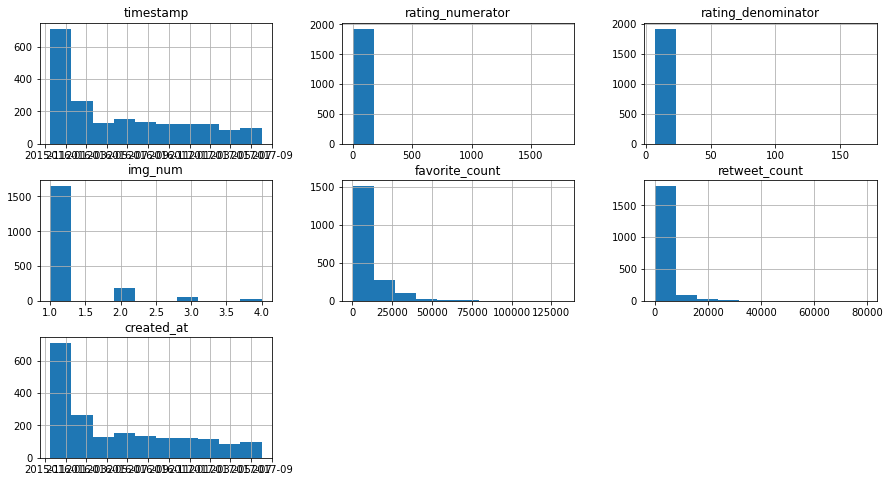

In [70]:
master_df.hist(figsize = (15, 8))

Rating numerator, denominator and retweet_count are the most skewed to the right

### __Which rating is most popular__?

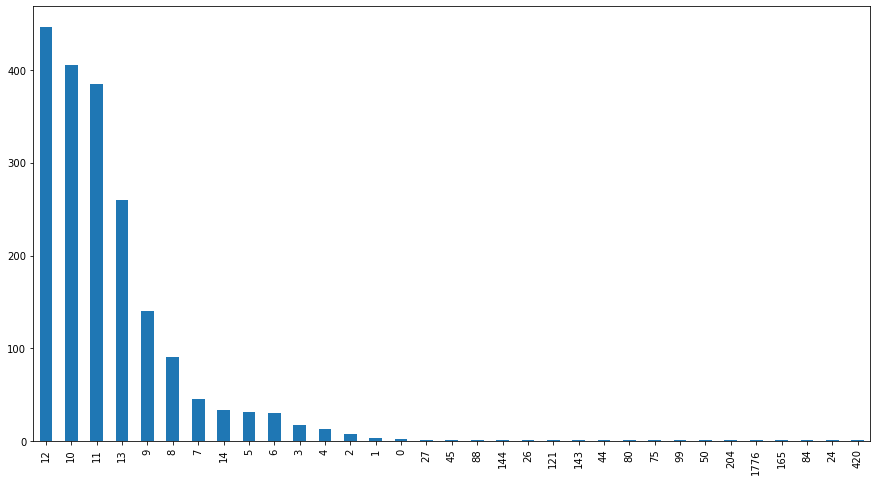

In [71]:
master_df.rating_numerator.value_counts().plot(kind = 'bar', figsize = (15, 8));

The three most popular and recurring ratings are __12__, __10__ and __11__

### What is the relationship between favorite_count and creation date if any?

<AxesSubplot:xlabel='created_at', ylabel='favorite_count'>

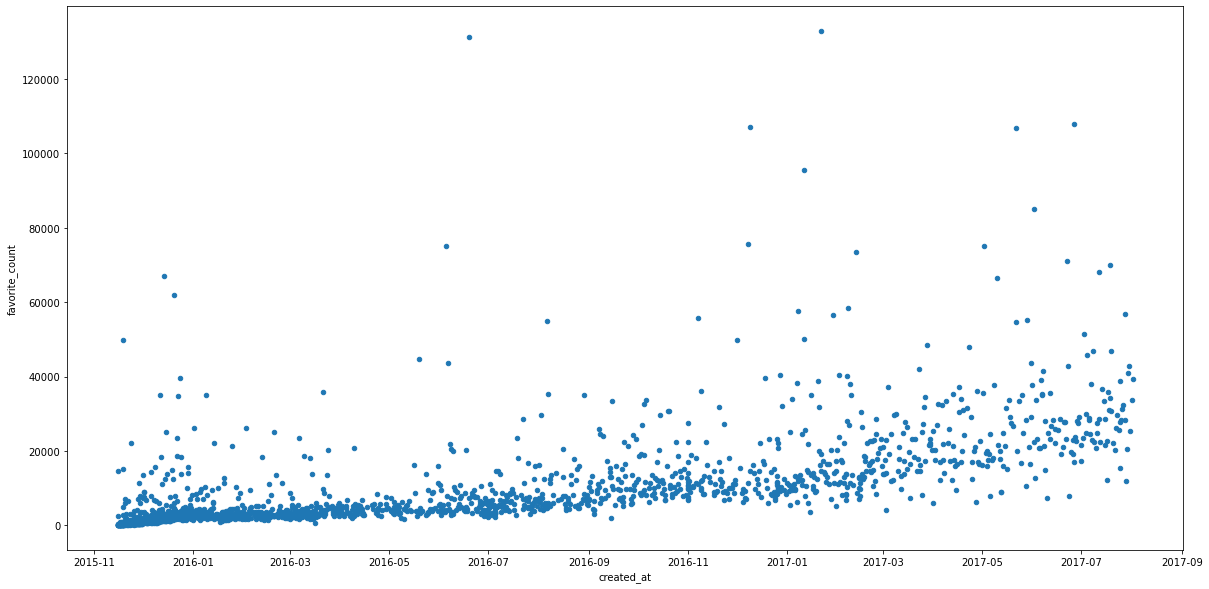

In [72]:
master_df.plot.scatter(x = 'created_at', y = 'favorite_count', figsize = (20, 10))

There seems to be a positive correlation between favorite_count and the date of creation.\
The later the creation, the greater the count

### __What are the most popular dog stages__?

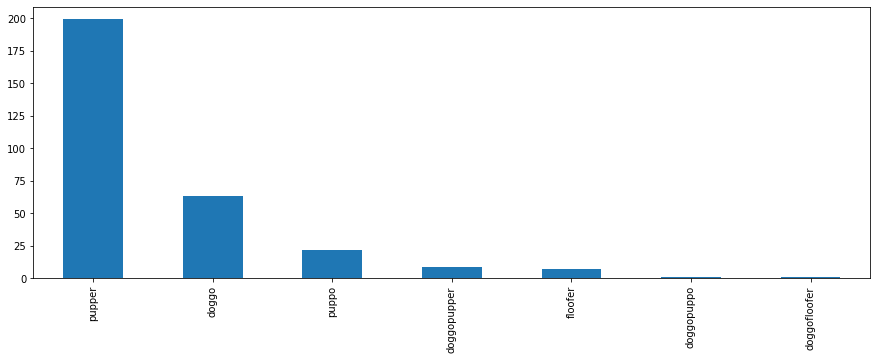

In [73]:
master_df.dog_stage.value_counts().plot(kind = 'bar', figsize = (15, 5));

The three most popular dog stages are __pupper__, __doggo__, and __puppo__